# **Importing the Data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from joblib import Parallel, delayed
import os
import multiprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data1 = pd.read_csv("Data/b011early.csv")
data2 = pd.read_csv("Data/b011late.csv")
ozone_data = pd.concat([data1,data2])
ozone_data = ozone_data.reset_index()

# **Preprocessing**

Select the data where that will be used for the model which includes the hourly data from 2008 to 2019. The unnecessary columns are moved to only keep the columns with concentration values and the date and time at which each concentration is measured.

## Making Concentration values NA for validity = 0 and validity = 1

In [5]:
ozone_data.head()

,index,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
0,0,BE/SPO-BETB011_00007_100,7,1992-01-01T00:00:00,1992-01-01T01:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN
1,1,BE/SPO-BETB011_00007_100,7,1992-01-01T01:00:00,1992-01-01T02:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN
2,2,BE/SPO-BETB011_00007_100,7,1992-01-01T02:00:00,1992-01-01T03:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN
3,3,BE/SPO-BETB011_00007_100,7,1992-01-01T03:00:00,1992-01-01T04:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN
4,4,BE/SPO-BETB011_00007_100,7,1992-01-01T04:00:00,1992-01-01T05:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN


In [6]:
ozone_data['Validity'].unique()

array([-1,  1,  0])

In [7]:
#Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity -1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETB011_00007_100          7  1992-01-01T00:00:00   
1      1  BE/SPO-BETB011_00007_100          7  1992-01-01T01:00:00   
2      2  BE/SPO-BETB011_00007_100          7  1992-01-01T02:00:00   
3      3  BE/SPO-BETB011_00007_100          7  1992-01-01T03:00:00   
4      4  BE/SPO-BETB011_00007_100          7  1992-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1992-01-01T01:00:00 -999.0  ug.m-3    hour        -1             1   
1  1992-01-01T02:00:00 -999.0  ug.m-3    hour        -1             1   
2  1992-01-01T03:00:00 -999.0  ug.m-3    hour        -1             1   
3  1992-01-01T04:00:00 -999.0  ug.m-3    hour        -1             1   
4  1992-01-01T05:00:00 -999.0  ug.m-3    hour        -1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530          0.0              Na

In [8]:
# Check rows with Validity = 0 or Validity = -1 and set Value to NaN
ozone_data.loc[(ozone_data['Validity'] == 0) | (ozone_data['Validity'] == -1), 'Value'] = None

In [9]:
#Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity -1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETB011_00007_100          7  1992-01-01T00:00:00   
1      1  BE/SPO-BETB011_00007_100          7  1992-01-01T01:00:00   
2      2  BE/SPO-BETB011_00007_100          7  1992-01-01T02:00:00   
3      3  BE/SPO-BETB011_00007_100          7  1992-01-01T03:00:00   
4      4  BE/SPO-BETB011_00007_100          7  1992-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1992-01-01T01:00:00    NaN  ug.m-3    hour        -1             1   
1  1992-01-01T02:00:00    NaN  ug.m-3    hour        -1             1   
2  1992-01-01T03:00:00    NaN  ug.m-3    hour        -1             1   
3  1992-01-01T04:00:00    NaN  ug.m-3    hour        -1             1   
4  1992-01-01T05:00:00    NaN  ug.m-3    hour        -1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530          0.0              Na

In [10]:
columns_remove = ['Samplingpoint','Pollutant','End','Unit','AggType','Validity','Verification','ResultTime','DataCapture','FkObservationLog','index']
ozone_data = ozone_data.drop(columns=columns_remove)

# Sampling Point: BE/SPO-BETN073_00007_100
# Pollutant: 7 (O_3)
# End: Start with 1 hour added
# Unit: ug.m-3
# Aggregation Type: hour
# Validaity/Verification: 1 & 1
# Result Time: Time and Date when data is added to the whole data file
# Data Capture: 0
# FkObservation log: Do not know meaning, values from NaN to 0fa5da4d-ae92-4bb7-bcd4-07fb6b962ae4

ozone_data['Start'] = pd.to_datetime(ozone_data['Start'])
data = ozone_data[(ozone_data['Start'].dt.year >= 2007) & (ozone_data['Start'].dt.year <= 2019)]
data = data.reset_index()
data = data.drop(columns=['index'])
data.rename(columns={'Value': 'Concentration'}, inplace=True)

Thus the following dataframe only

In [11]:
data.head()

,Start,Concentration
0,2007-01-01 00:00:00,63.0
1,2007-01-01 01:00:00,75.0
2,2007-01-01 02:00:00,74.0
3,2007-01-01 03:00:00,71.0
4,2007-01-01 04:00:00,74.0


The data is checked to make sure there are no duplicates.

In [12]:
duplicates = data.duplicated(subset=['Start'])

# Print or further process the duplicate values
print("Duplicate values in the column Start:", duplicates.any())

Duplicate values in the column Start: False


## Adding new variables

From the Start column, we extracr the year, month, day and time.

In [13]:
# Extract year, month, day, and time into separate columns
data['Year'] = data['Start'].dt.year
data['Month'] = data['Start'].dt.month
data['Day'] = data['Start'].dt.day
data['Time'] = data['Start'].dt.time

# Display the transformed DataFrame
print(data.head())

                Start  Concentration  Year  Month  Day      Time
0 2007-01-01 00:00:00           63.0  2007      1    1  00:00:00
1 2007-01-01 01:00:00           75.0  2007      1    1  01:00:00
2 2007-01-01 02:00:00           74.0  2007      1    1  02:00:00
3 2007-01-01 03:00:00           71.0  2007      1    1  03:00:00
4 2007-01-01 04:00:00           74.0  2007      1    1  04:00:00


From the Start column the day of the week can be extracted, which can also be used to determine if that measurement was taken during the weekend.

In [14]:
# Extract day of the week
data['DayOfWeek'] = (data['Start'].dt.weekday + 1) % 7

# Create a new column indicating whether the day is a weekend or not
data['Weekend'] = (data['Start'].dt.dayofweek // 5).astype(int)

In [15]:
data.head()

,Start,Concentration,Year,Month,Day,Time,DayOfWeek,Weekend
0,2007-01-01 00:00:00,63.0,2007,1,1,00:00:00,1,0
1,2007-01-01 01:00:00,75.0,2007,1,1,01:00:00,1,0
2,2007-01-01 02:00:00,74.0,2007,1,1,02:00:00,1,0
3,2007-01-01 03:00:00,71.0,2007,1,1,03:00:00,1,0
4,2007-01-01 04:00:00,74.0,2007,1,1,04:00:00,1,0


## Converting the negative values

Missing values are represented by negative concentration values. Thus, these will be converted to NaN to be able to used the describe function to attain some basic measures.

In [16]:
# Can check the issue here
data['Concentration'].describe()

count    110706.000000
mean         42.252958
std          29.307746
min           2.000000
25%          19.000000
50%          41.000000
75%          60.000000
max         237.000000
Name: Concentration, dtype: float64

In [17]:
count_below_zero = (data['Concentration'] < 0).sum()

# Print the count
print("Number of observations with values below 0:", count_below_zero)

data.loc[data['Concentration'] < 0, 'Concentration'] = np.nan

Number of observations with values below 0: 0


In [18]:
data['Concentration'].isna().sum()

3101

In [19]:
data['Concentration'].describe()

count    110706.000000
mean         42.252958
std          29.307746
min           2.000000
25%          19.000000
50%          41.000000
75%          60.000000
max         237.000000
Name: Concentration, dtype: float64

## Making the data daily, using 8 hour Mean Max



In [20]:
# Calculate the 8-hour rolling mean
eight_hour_rolling_mean = data.groupby(['Year', 'Month', 'Day'])['Concentration'].rolling(window=8).mean().reset_index(drop=True)

# Add the 8-hour rolling mean as a new column in the original DataFrame
data['EightHourRollingMean'] = eight_hour_rolling_mean

# Group by 'Year', 'Month', and 'Day', and find the daily maximum of the 8-hour mean
data = data.groupby(['Year', 'Month', 'Day']).agg({'EightHourRollingMean': 'max', 'DayOfWeek': 'first', 'Weekend': 'first'}).reset_index()

In [21]:
data.rename(columns={'EightHourRollingMean': 'Concentration'}, inplace=True)

In [22]:
nan_count = data['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 41


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4742 entries, 0 to 4741
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4742 non-null   int32  
 1   Month          4742 non-null   int32  
 2   Day            4742 non-null   int32  
 3   Concentration  4701 non-null   float64
 4   DayOfWeek      4742 non-null   int32  
 5   Weekend        4742 non-null   int64  
dtypes: float64(1), int32(4), int64(1)
memory usage: 148.3 KB


In [24]:
# Check for NaN values in the entire DataFrame
nan_rows = data[data.isna().any(axis=1)]

# Print the rows with NaN values
print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
      Year  Month  Day  Concentration  DayOfWeek  Weekend
71    2007      3   13            NaN          2        0
72    2007      3   14            NaN          3        0
288   2007     10   16            NaN          2        0
435   2008      3   11            NaN          2        0
436   2008      3   12            NaN          3        0
447   2008      3   23            NaN          0        1
448   2008      3   24            NaN          1        0
632   2008      9   24            NaN          3        0
633   2008      9   25            NaN          4        0
634   2008      9   26            NaN          5        0
635   2008      9   27            NaN          6        1
636   2008      9   28            NaN          0        1
659   2008     10   21            NaN          2        0
660   2008     10   22            NaN          3        0
661   2008     10   23            NaN          4        0
792   2009      3    3            NaN          2  

In [25]:
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

## Adding lagged MA or MM

In [26]:
# Calculating the moving average and median excluding the current row's value
data['lagged_ma_7'] = data['Concentration'].shift(1).rolling(window=7).mean()
data['lagged_mm_7'] = data['Concentration'].shift(1).rolling(window=7).median()

In [27]:
data.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend,lagged_ma_7,lagged_mm_7
Date,,,,,,,,
2007-01-01,2007,1,1,74.500,1,0,NaN,NaN
2007-01-02,2007,1,2,55.000,2,0,NaN,NaN
2007-01-03,2007,1,3,40.500,3,0,NaN,NaN
2007-01-04,2007,1,4,54.875,4,0,NaN,NaN
2007-01-05,2007,1,5,40.125,5,0,NaN,NaN


# **ARIMA model**

## A new variable based on the optimal SARIMA is made

In [28]:
### We first create a new dataset,interpolate the missing values so that we can perform ARIMA
# Assuming data is your DataFrame
data_a = data.copy()

In [29]:
data_a['Concentration'] = data_a['Concentration'].interpolate(method='linear')

In [30]:
# Assuming data_a is your DataFrame
columns_to_drop = ['Year', 'Month', 'Day', 'DayOfWeek', 'Weekend', 'lagged_ma_7', 'lagged_mm_7']

# Drop the specified columns from data_a
data_a = data_a.drop(columns=columns_to_drop)

data_a.isna().sum()
data_a.head()

,Concentration
Date,
2007-01-01,74.500
2007-01-02,55.000
2007-01-03,40.500
2007-01-04,54.875
2007-01-05,40.125


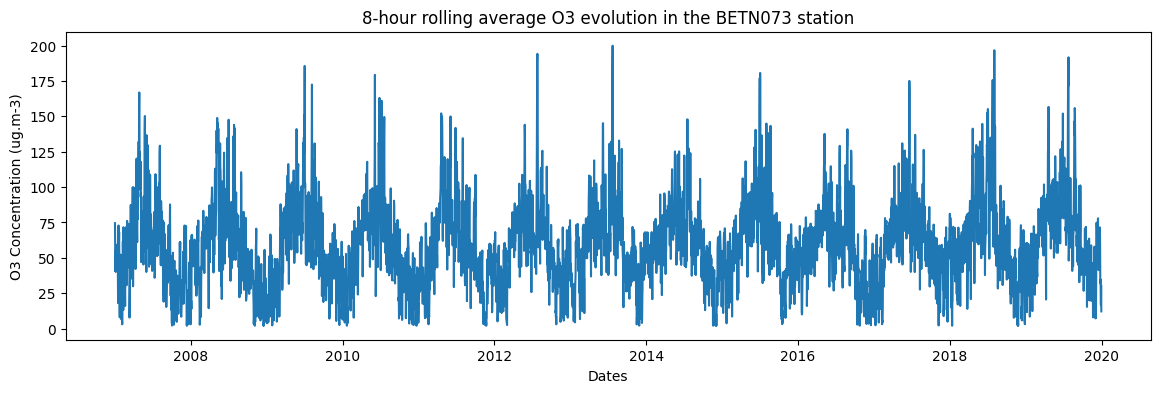

In [31]:
plt.figure(figsize=(14,4))
plt.title('8-hour rolling average O3 evolution in the BETN073 station')
plt.xlabel('Dates')
plt.ylabel('O3 Concentration (ug.m-3)')
plt.plot(data_a.Concentration)

In [32]:
data_b = data_a.copy()
data_b = data_b.reset_index()

In [33]:
data_b

,Date,Concentration
0,2007-01-01,74.5000
1,2007-01-02,55.0000
2,2007-01-03,40.5000
3,2007-01-04,54.8750
4,2007-01-05,40.1250
...,...,...
4737,2019-12-27,34.6875
4738,2019-12-28,26.0625
4739,2019-12-29,16.5000
4740,2019-12-30,30.6875


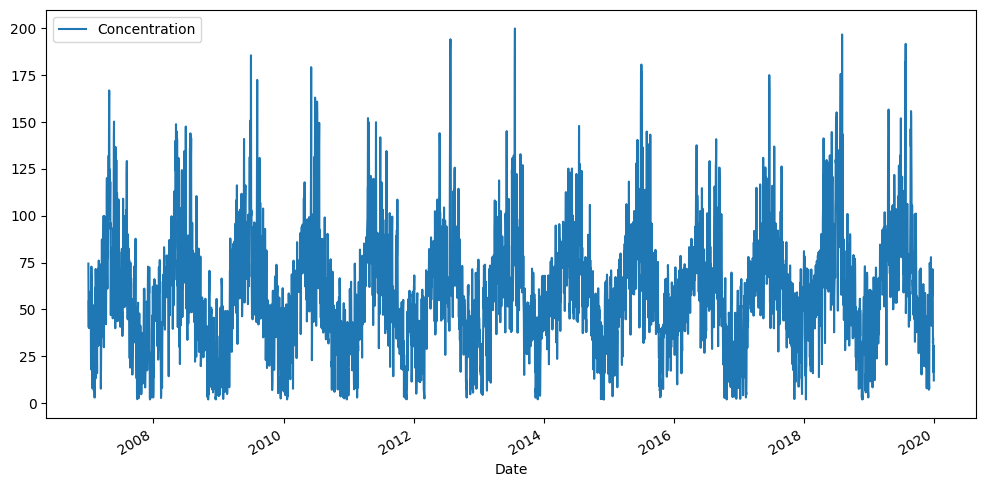

In [34]:
data_b['Date'] = pd.to_datetime(data_b['Date'])  # Convert date column to DateTime
ax = data_b.plot(x='Date', y='Concentration', figsize=(12, 6))

plt.show()

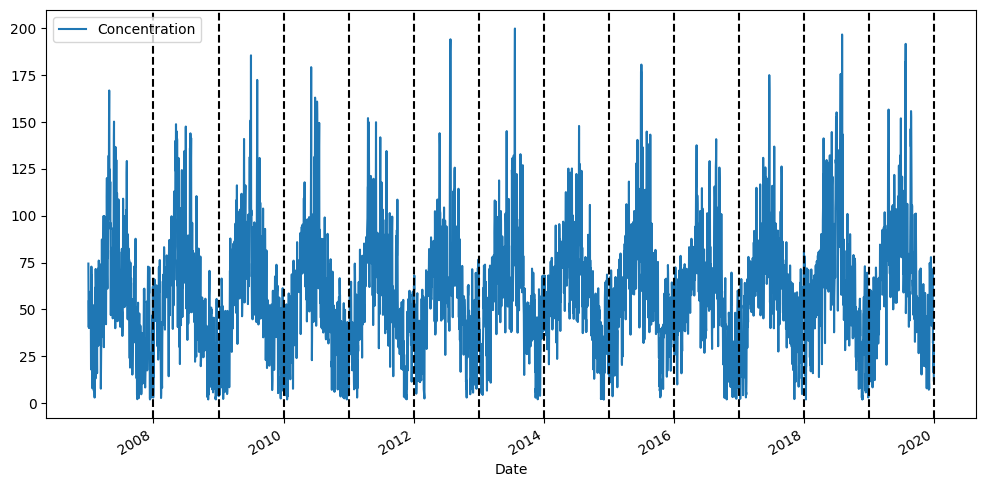

In [35]:
ax = data_b.plot(x='Date', y='Concentration', figsize=(12,6))
xcoords = ['2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

We can slightly observe seasonality

In [36]:
data_a.dropna(subset=['Concentration'], inplace=True)

In [37]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data_a)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -5.326017508886002
p-value: 4.835528093059186e-06
Critical Values: {'1%': -3.4317376699258304, '5%': -2.862153191895276, '10%': -2.5670964041905022}
The time series is likely stationary.


## Analysed stationarity

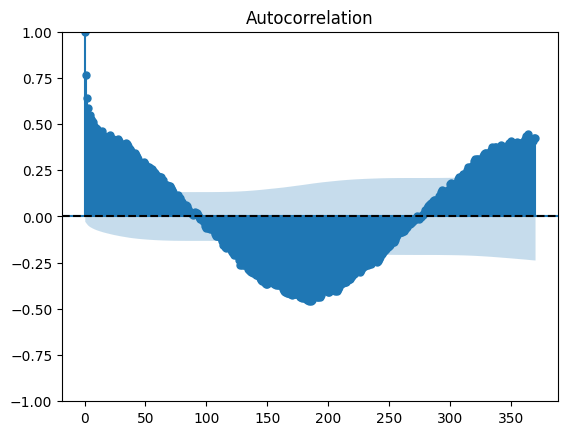

In [38]:
acf_plot = plot_acf(data_a.Concentration, lags=370)
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

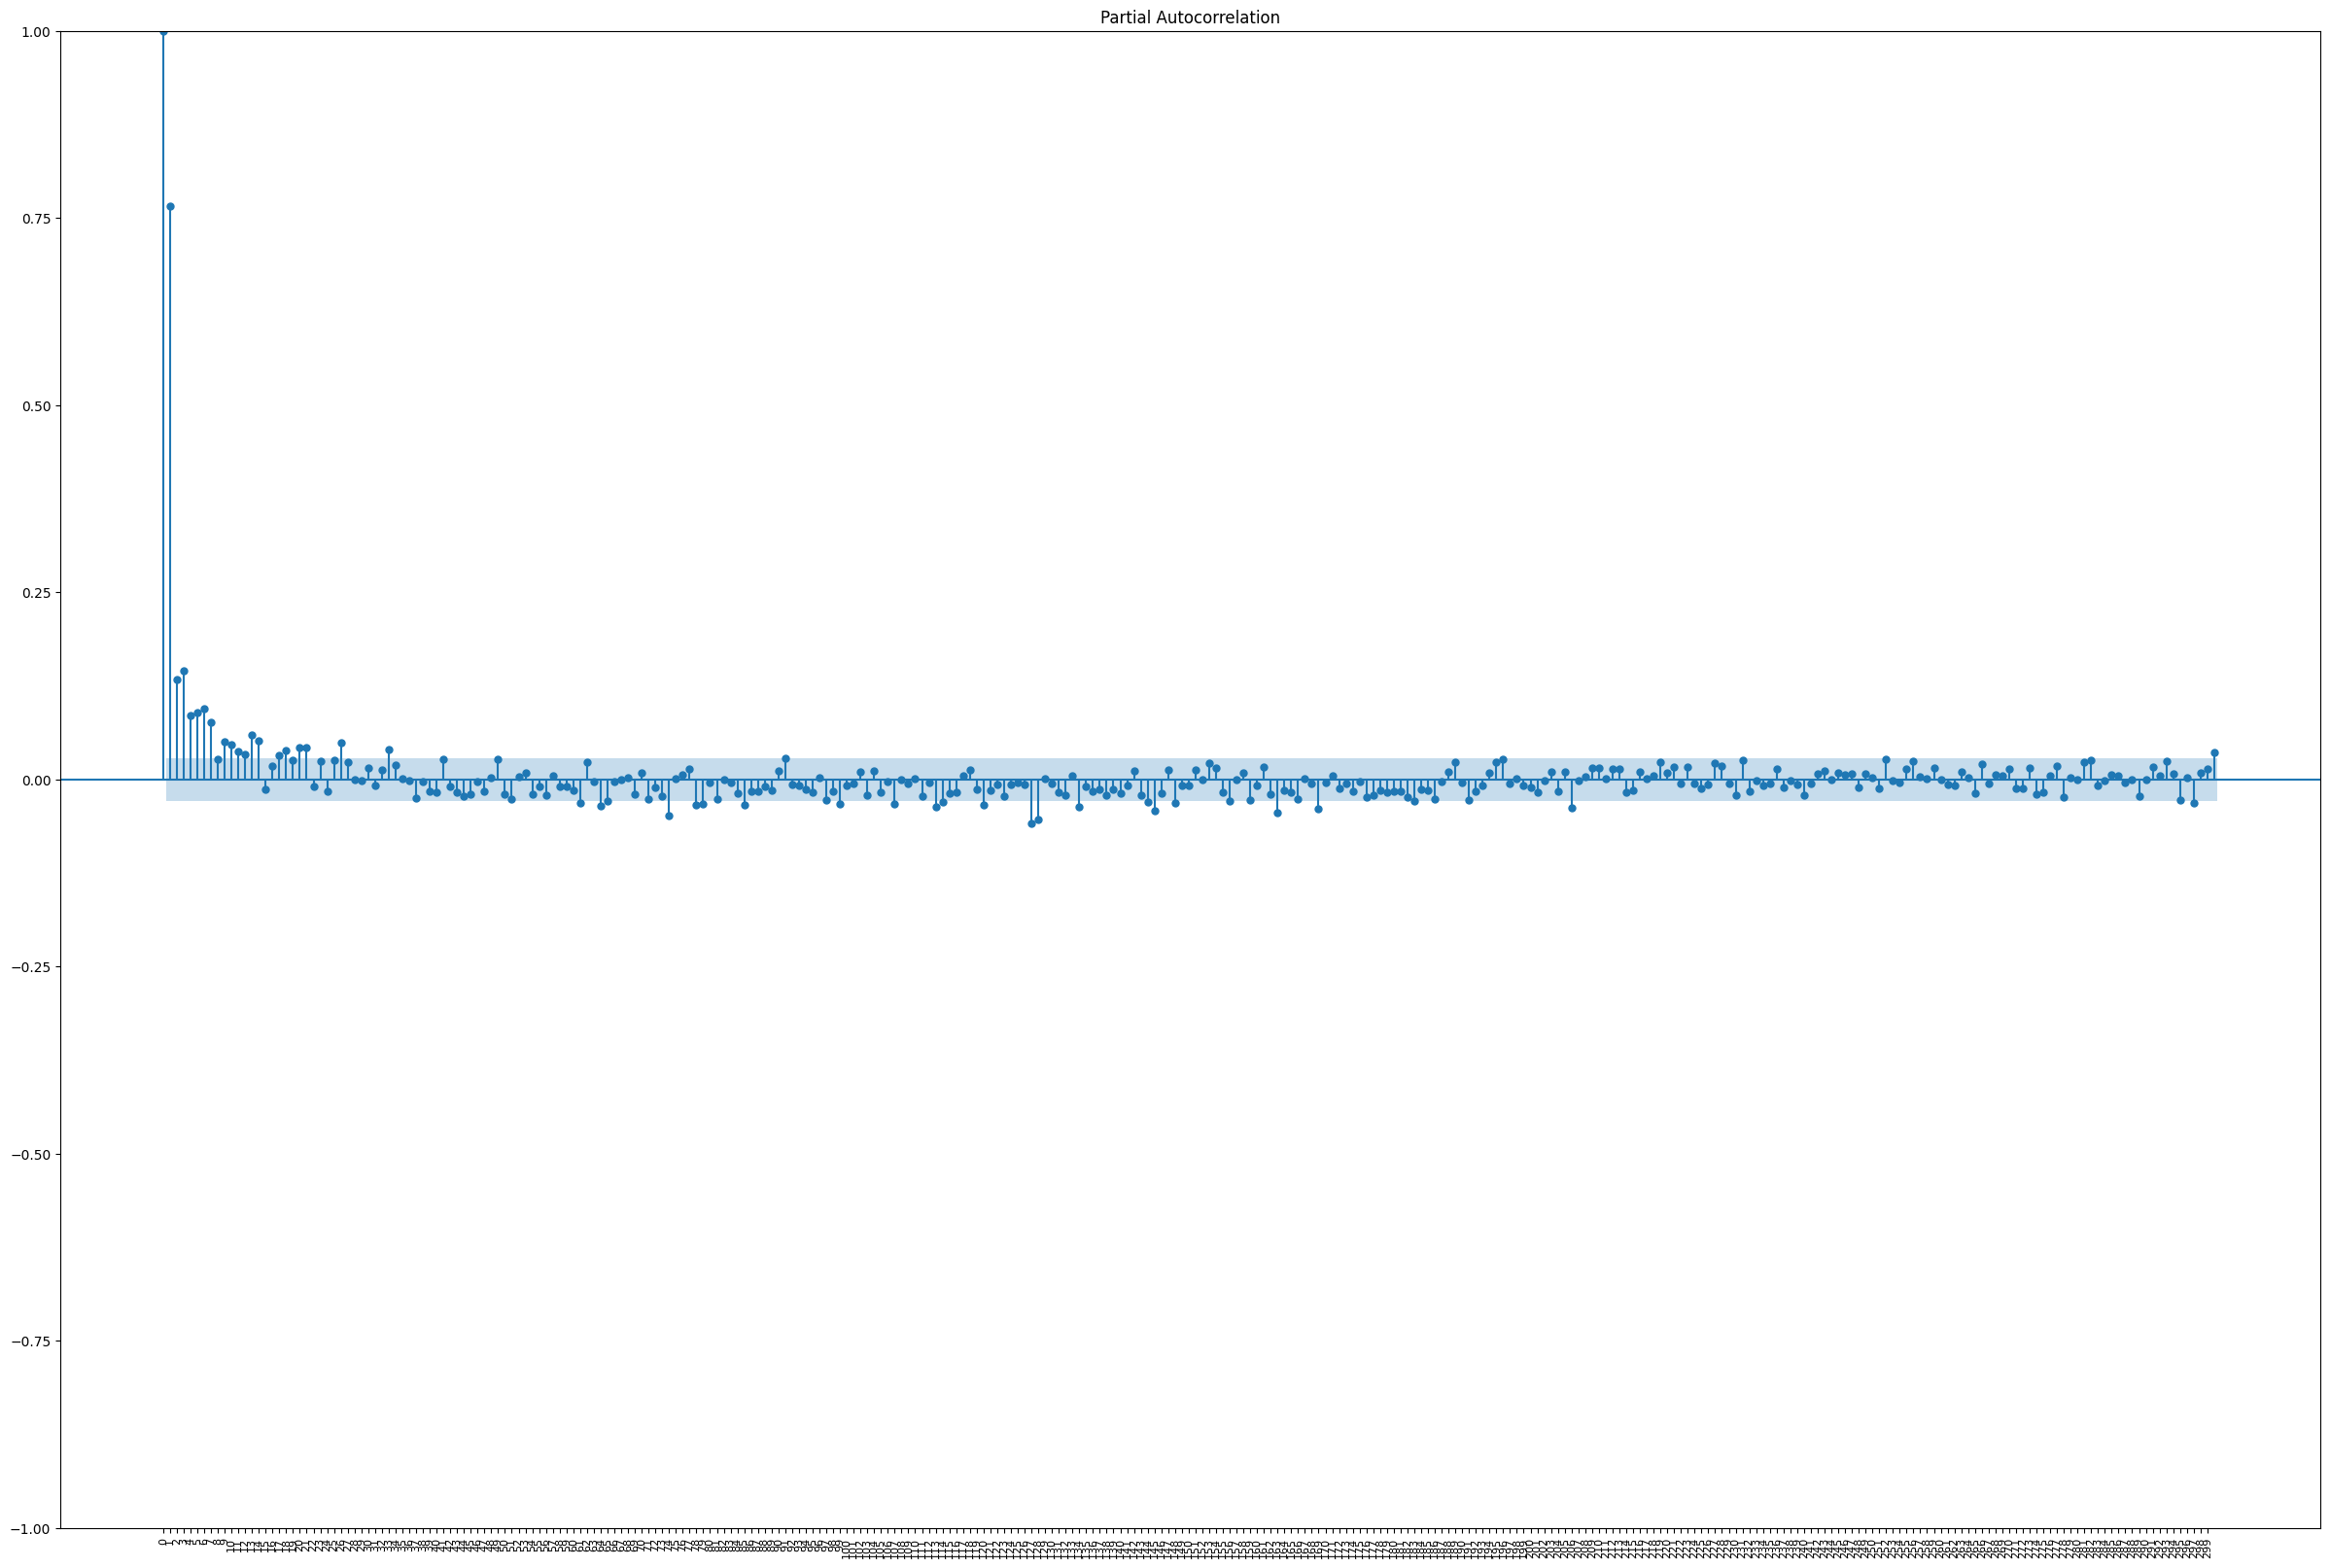

In [39]:
# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(30, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(data_a['Concentration'], lags=300, ax=ax)

# Display the plot
plt.xticks(range(300), rotation='vertical', fontsize=8)
plt.show()

## ARIMA BLOCK OF CODE

In [40]:
"""# Define the range of AR, MA, and seasonality values to check
ar_range = range(12)
ma_range = range(12)

# Initialize variables for tracking the best model
best_mse = float('inf')
best_order = None
best_results = None

# Iterate through AR and MA values
for p in ar_range:
    for q in ma_range:
        order = (p, 0, q)  # ARIMA order (p, d, q), here d=0 for ARMA
        model = sm.tsa.ARIMA(data_a['Concentration'], order=order)
        results = model.fit()

        # Calculate Mean Squared Error (MSE)
        fitted_values = results.fittedvalues
        mse = mean_squared_error(data_a['Concentration'], fitted_values)

        # Check if the current model has a lower MSE than the best so far
        if mse < best_mse:
            best_mse = mse
            best_order = order
            best_results = results

# Display the best model's information including AIC, BIC, MSE, and summary
print(f'Best Model Order: {best_order}')
print(f'Best Model AIC: {best_results.aic:.2f}')
print(f'Best Model BIC: {best_results.bic:.2f}')
print(f'Best Model MSE: {best_mse:.2f}')
print(best_results.summary())"""

"# Define the range of AR, MA, and seasonality values to check\nar_range = range(12)\nma_range = range(12)\n\n# Initialize variables for tracking the best model\nbest_mse = float('inf')\nbest_order = None\nbest_results = None\n\n# Iterate through AR and MA values\nfor p in ar_range:\n    for q in ma_range:\n        order = (p, 0, q)  # ARIMA order (p, d, q), here d=0 for ARMA\n        model = sm.tsa.ARIMA(data_a['Concentration'], order=order)\n        results = model.fit()\n\n        # Calculate Mean Squared Error (MSE)\n        fitted_values = results.fittedvalues\n        mse = mean_squared_error(data_a['Concentration'], fitted_values)\n\n        # Check if the current model has a lower MSE than the best so far\n        if mse < best_mse:\n            best_mse = mse\n            best_order = order\n            best_results = results\n\n# Display the best model's information including AIC, BIC, MSE, and summary\nprint(f'Best Model Order: {best_order}')\nprint(f'Best Model AIC: {best_r

In [41]:
best_order = (8, 0, 10)

In [42]:
# Fit ARMA (8, 0, 10)
order_arma = best_order  # ARIMA order (p, d, q), here d=0 for ARMA
model_arma = sm.tsa.ARIMA(data_a['Concentration'], order=order_arma)
results_arma = model_arma.fit()

# Extract the predicted (fitted) values
fitted_values = pd.DataFrame({
    'FittedValues': results_arma.fittedvalues
})

# Combine the original data_a DataFrame with the fitted values
data['FittedValues'] = fitted_values['FittedValues']

# Display the updated DataFrame
print(data)

results_arma.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            Year  Month  Day  Concentration  DayOfWeek  Weekend  lagged_ma_7  \
Date                                                                           
2007-01-01  2007      1    1        74.5000          1        0          NaN   
2007-01-02  2007      1    2        55.0000          2        0          NaN   
2007-01-03  2007      1    3        40.5000          3        0          NaN   
2007-01-04  2007      1    4        54.8750          4        0          NaN   
2007-01-05  2007      1    5        40.1250          5        0          NaN   
...          ...    ...  ...            ...        ...      ...          ...   
2019-12-27  2019     12   27        34.6875          5        0    58.330357   
2019-12-28  2019     12   28        26.0625          6        1    53.964286   
2019-12-29  2019     12   29        16.5000          0        1    49.562500   
2019-12-30  2019     12   30        30.6875          1        0    42.892857   
2019-12-31  2019     12   31        12.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Concentration   No. Observations:                 4742
Model:                ARIMA(8, 0, 10)   Log Likelihood              -20519.714
Date:                Wed, 29 May 2024   AIC                          41079.428
Time:                        10:52:33   BIC                          41208.713
Sample:                             0   HQIC                         41124.862
                               - 4742                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.4158      4.703     12.634      0.000      50.198      68.633
ar.L1          0.7680      0.116      6.608      0.000       0.540       0.996
ar.L2         -0.1111      0.151     -0.737      0.461      -0.407       0.184
ar.L3          0.0376      0.145      0.259      0.795      -0.247       0.322
ar.L4          0.0396      0.132      0.300      0.764      -0.219       0.298
ar.L5         -0.1008      0.121     -0.835      0.404      -0.337       0.136
ar.L6          0.1315      0.121      1.085      0.278      -0.106       0.369
ar.L7          0.8183      0.131      6.265      0.000       0.562       1.074
ar.L8         -0.6052      0.095     -6.399      0.000      -0.791      -0.420
ma.L1         -0.1836      0.117     -1.574      0.115      -0.412       0.045
ma.L2          0.0233      0.116      0.201      0.841      -0.204       0.251
ma.L3          0.0311      0.093      0.335      0.738      -0.151       0.213
ma.L4         -0.0112      0.092     -0.123      0.902      -0.191       0.168
ma.L5          0.1270      0.081      1.575      0.115      -0.031       0.285
ma.L6         -0.0402      0.091     -0.444      0.657      -0.218       0.137
ma.L7         -0.8003      0.091     -8.755      0.000      -0.979      -0.621
ma.L8          0.1236      0.064      1.945      0.052      -0.001       0.248
ma.L9          0.0880      0.033      2.701      0.007       0.024       0.152
ma.L10         0.0020      0.022      0.089      0.929      -0.042       0.046
sigma2       336.7683      5.684     59.246      0.000     325.627     347.909
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               308.56
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.17
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model valid as Ljung-Box test is 0.05.

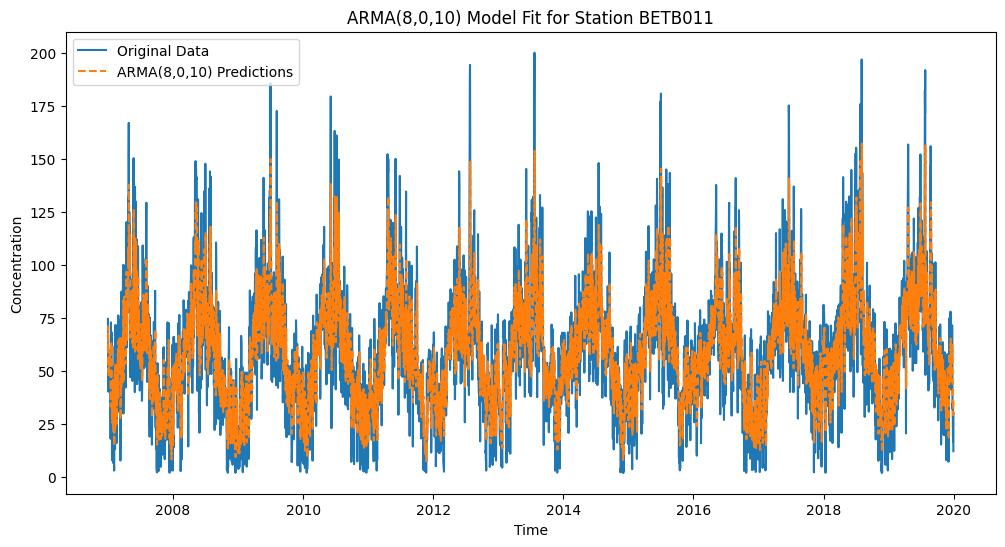

In [43]:
# Plot original data and predicted values
plt.figure(figsize=(12, 6))
plt.plot(data_a, label='Original Data')
plt.plot(results_arma.fittedvalues, label='ARMA(8,0,10) Predictions', linestyle='--')
plt.title('ARMA(8,0,10) Model Fit for Station BETB011')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

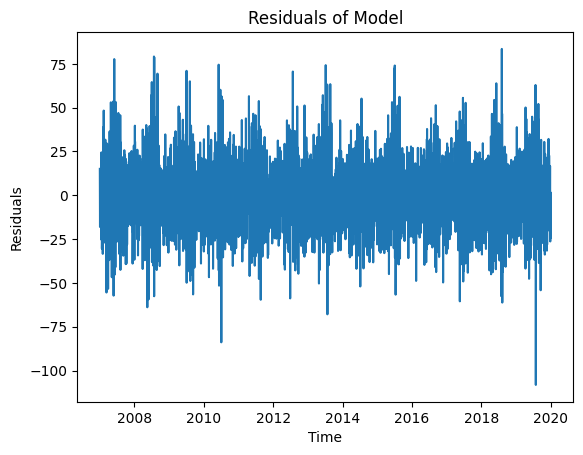

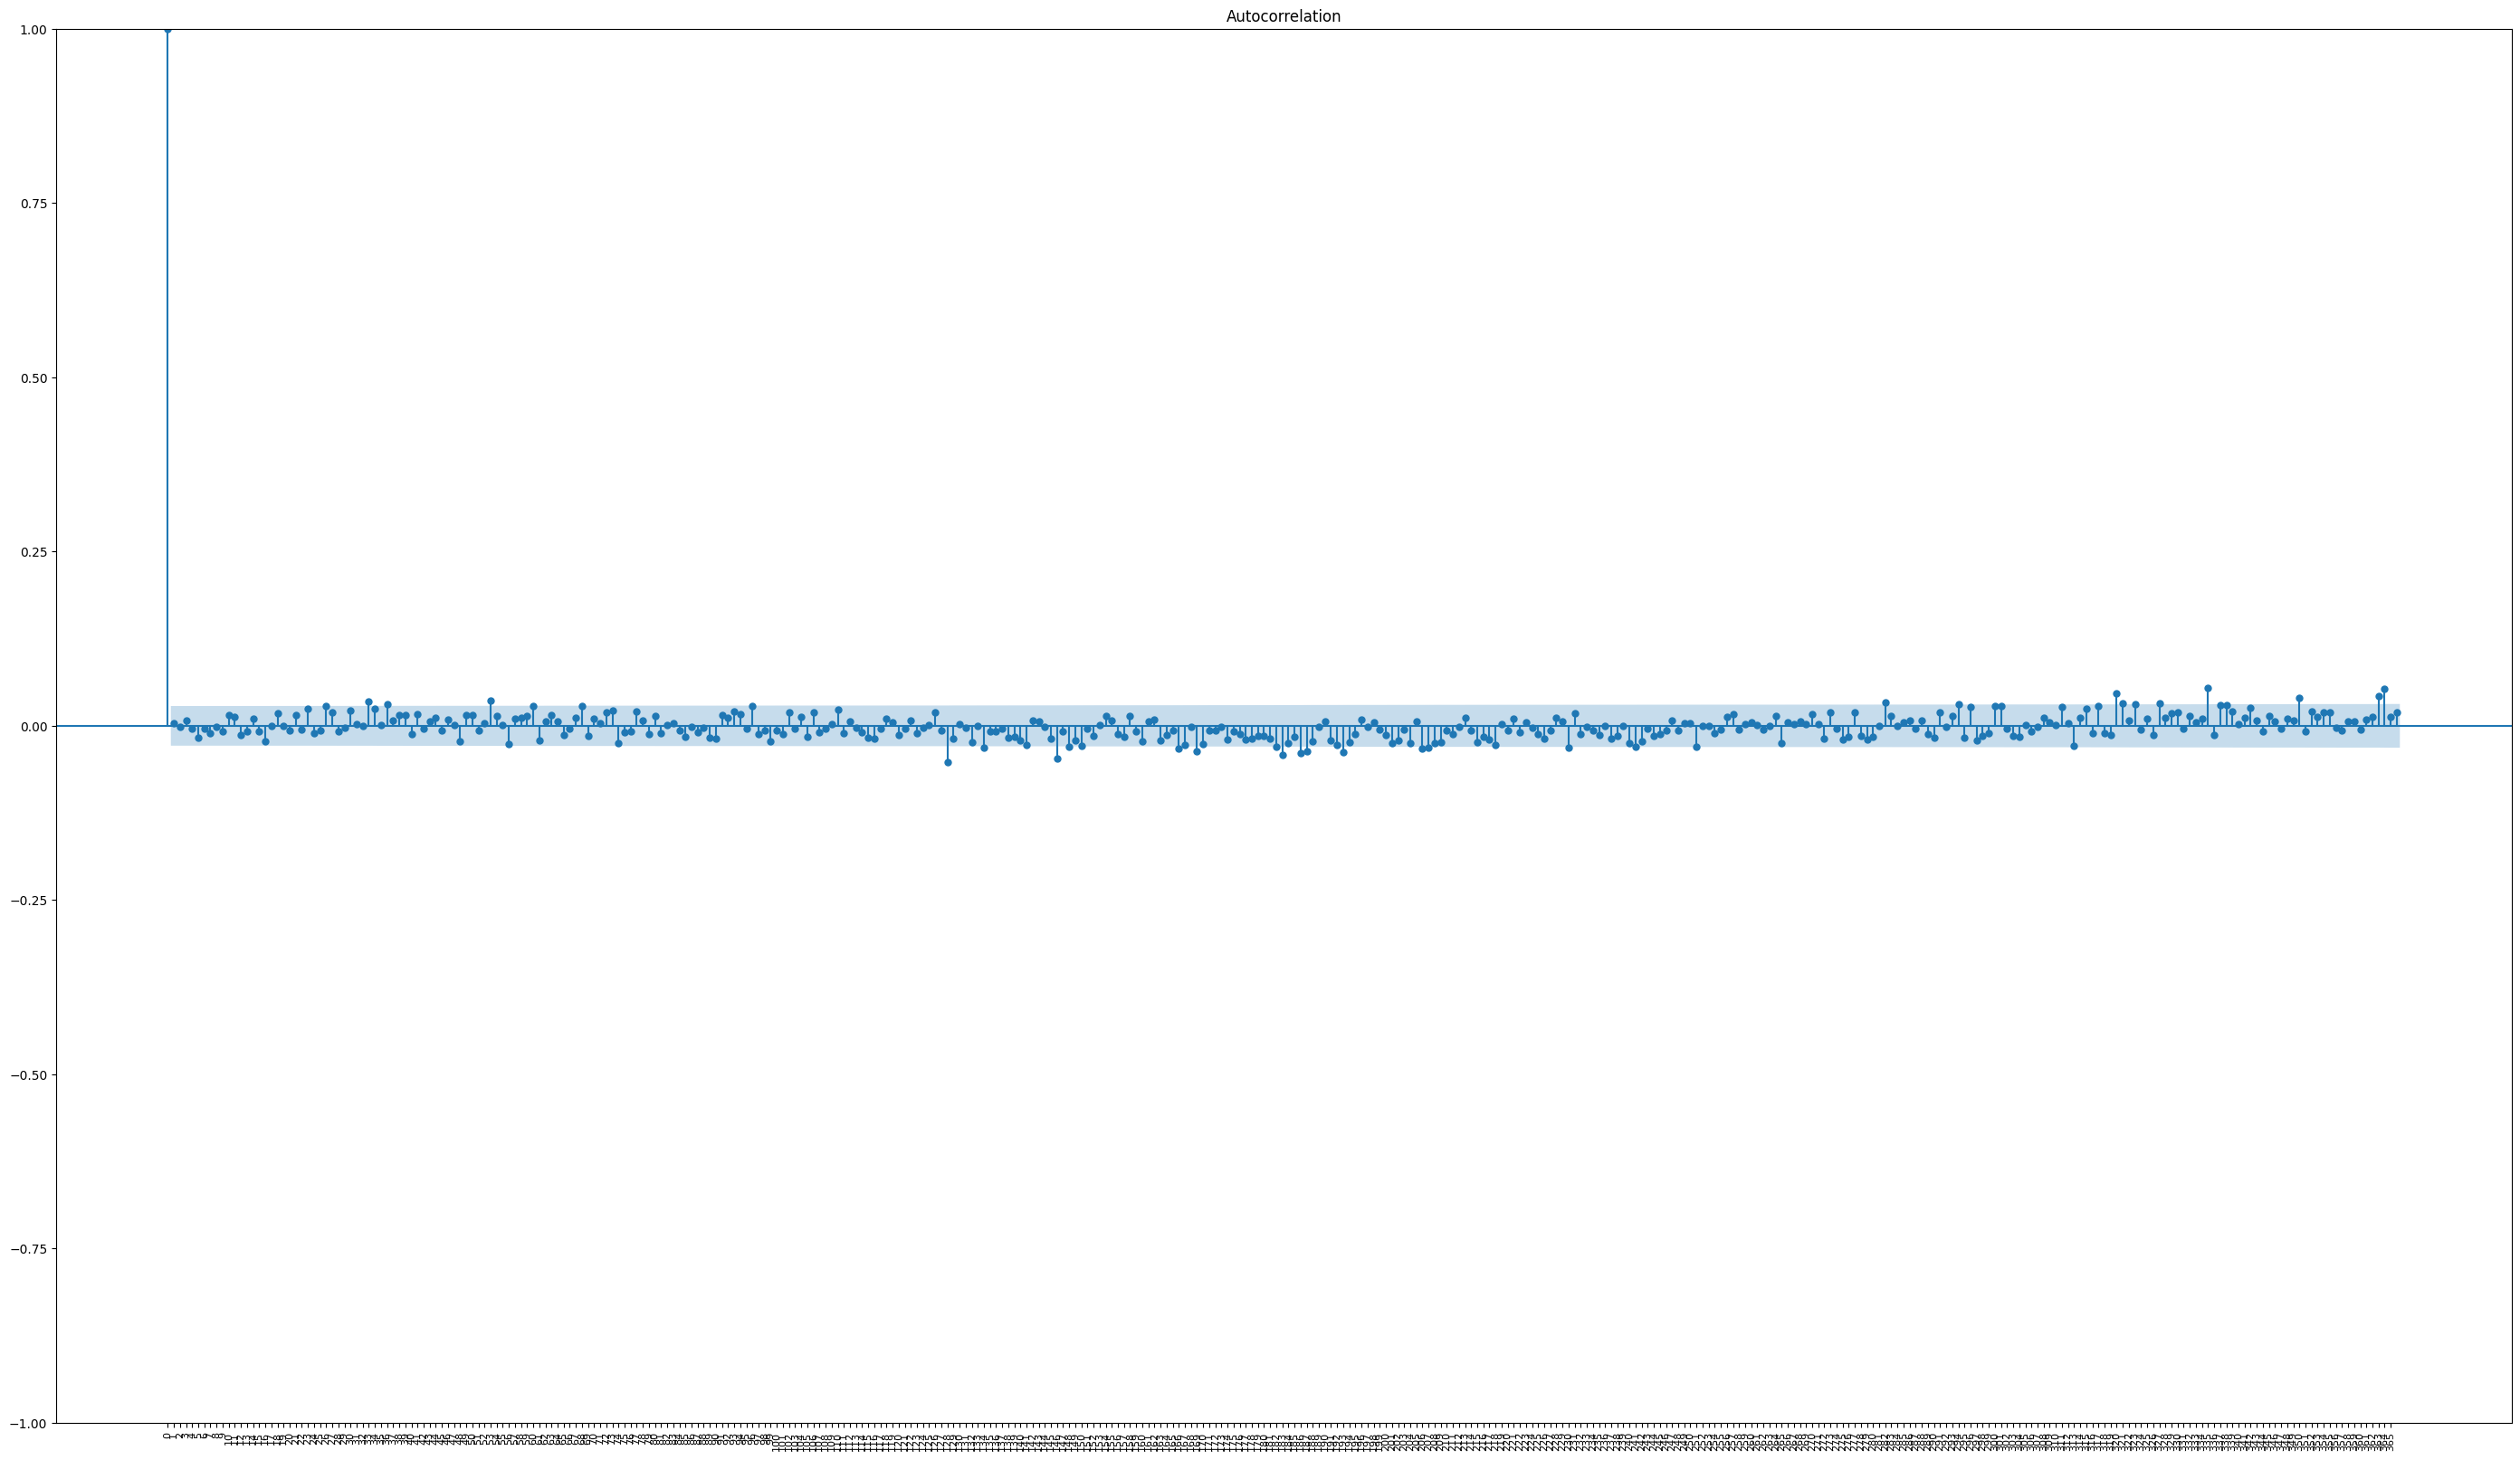

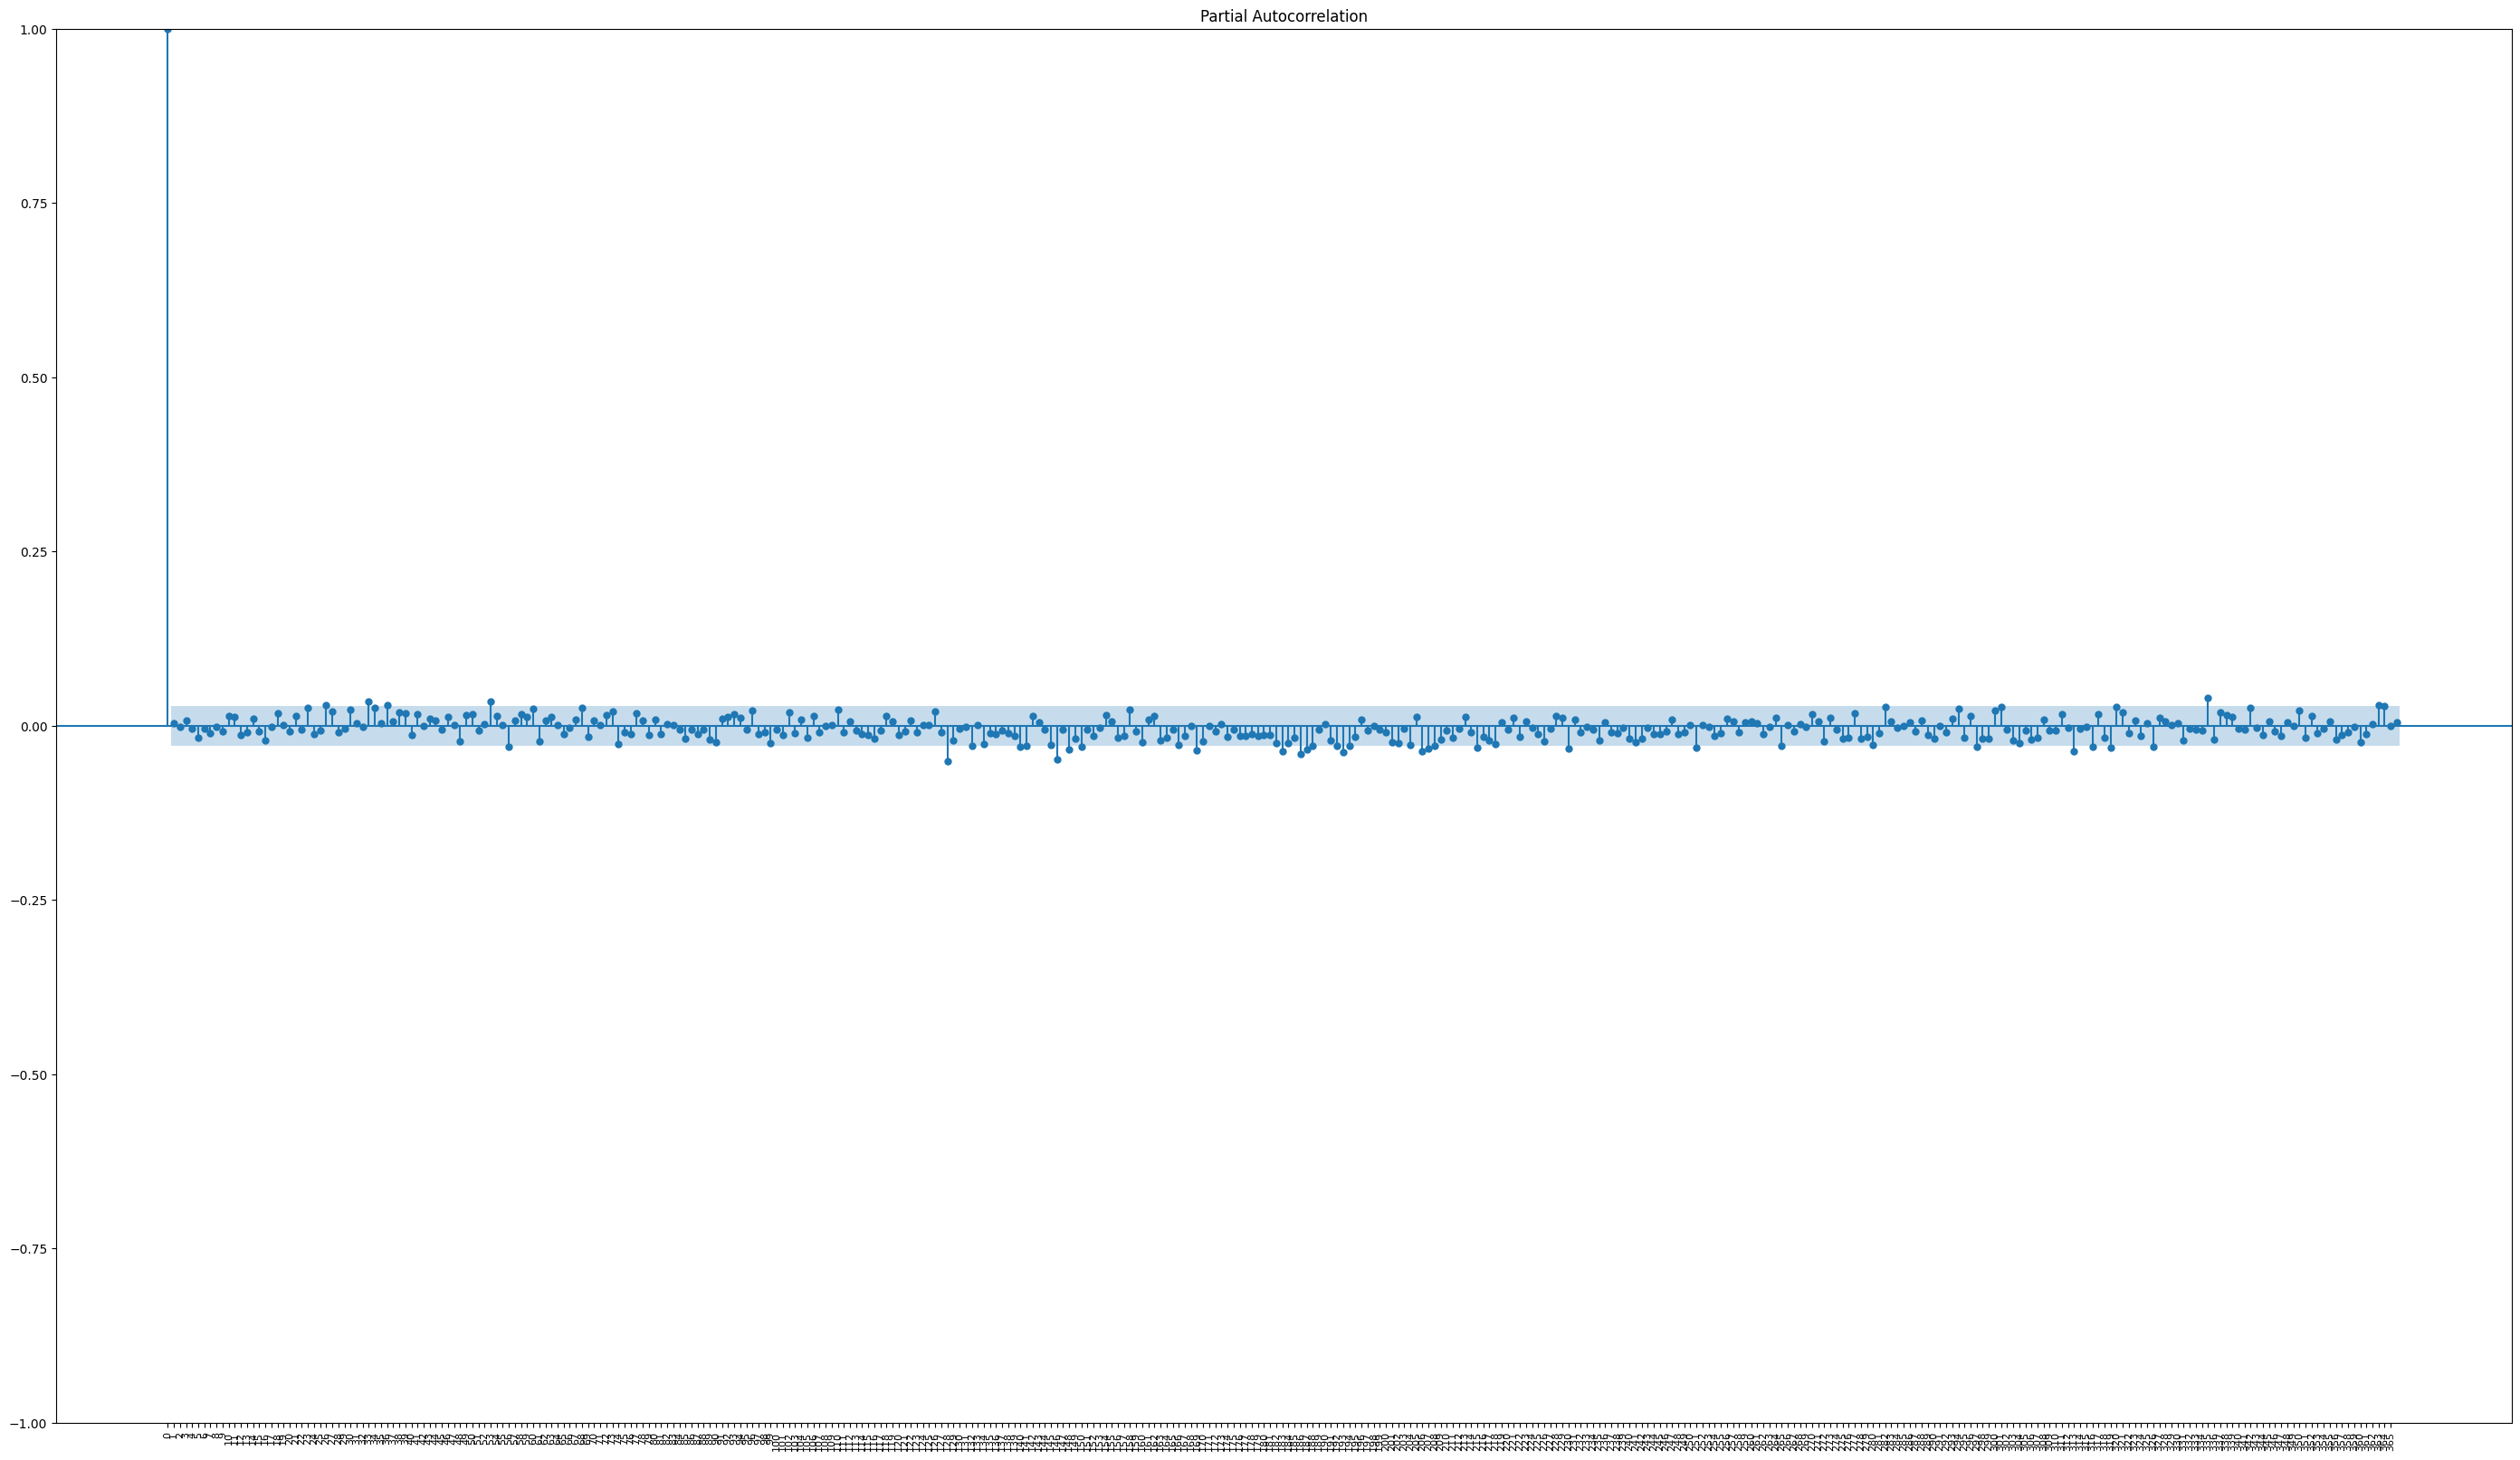

In [44]:
residuals = results_arma.resid

# Plot the residuals
plt.plot(residuals)
plt.title('Residuals of Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot ACF and PACF of residuals
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
acf_plot = plot_acf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()


# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()

In [45]:
# Remove NaN values from 'Concentration' and 'FittedValues' columns
mask = ~np.isnan(data['Concentration']) & ~np.isnan(data['FittedValues'])
y_true = data['Concentration'][mask]
y_pred = data['FittedValues'][mask]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Squared Error (MSE): 338.04


The MSE is very high, its 338.04

## Lagged values of Concentration feature creation (value from day before, a week before, a month before, and a year before)

In [46]:
# Assuming 'Date' is your index
data['day_lag1'] = data['Concentration'].shift(1)
data['day_lag7'] = data['Concentration'].shift(7)
data['day_fut1'] = data['Concentration'].shift(-1)
data['day_fut7'] = data['Concentration'].shift(-7)

In [47]:
# Assuming data is your DataFrame

#For month
def get_previous_day_concentration(row, data):
    prev_month = row['Month'] - 1
    prev_year = row['Year']
    prev_day = row['Day']

    if prev_month == 0:  # If the previous month is December, adjust year and month
        prev_month = 12
        prev_year -= 1

    # Check if previous day exists in the previous month
    prev_day_concentration = data.loc[
        (data['Year'] == prev_year) &
        (data['Month'] == prev_month) &
        (data['Day'] == prev_day),
        'Concentration'
    ]

    # If the previous day's concentration is not found, check the last day of the previous month
    if prev_day_concentration.empty:
        # Adjusting to the last day of the previous month (30 or 31)
        prev_day = 30 if prev_month in [4, 6, 9, 11] else 31 if prev_month != 2 else 28  # February special case
        prev_day_concentration = data.loc[
            (data['Year'] == prev_year) &
            (data['Month'] == prev_month) &
            (data['Day'] == prev_day),
            'Concentration'
        ]

    return prev_day_concentration.iloc[0] if not prev_day_concentration.empty else np.nan

data['day_lag30'] = data.apply(lambda row: get_previous_day_concentration(row, data) if row['Month'] > 1 else np.nan, axis=1)

#For future month
# Assuming data is your DataFrame

def get_next_day_concentration(row, data):
    next_month = row['Month'] + 1
    next_year = row['Year']
    next_day = row['Day']

    if next_month == 13:  # If the next month is January, adjust year and month
        next_month = 1
        next_year += 1

    # Check if next day exists in the next month
    next_day_concentration = data.loc[
        (data['Year'] == next_year) &
        (data['Month'] == next_month) &
        (data['Day'] == next_day),
        'Concentration'
    ]

    # If the next day's concentration is not found, check the last day of the next month
    if next_day_concentration.empty:
        # Adjusting to the last day of the next month (30 or 31)
        next_day = 30 if next_month in [4, 6, 9, 11] else 31 if next_month != 2 else 28  # February special case
        next_day_concentration = data.loc[
            (data['Year'] == next_year) &
            (data['Month'] == next_month) &
            (data['Day'] == next_day),
            'Concentration'
        ]

    return next_day_concentration.iloc[0] if not next_day_concentration.empty else np.nan

data['day_fut30'] = data.apply(lambda row: get_next_day_concentration(row, data) if row['Month'] < 12 else np.nan, axis=1)

#for last year
data['day_lag365'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year'] - 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Year'] > data['Year'].min() and not data.loc[
        (data['Year'] == row['Year'] - 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

#For future year
data['day_fut365'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year'] + 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Year'] > data['Year'].min() and not data.loc[
        (data['Year'] == row['Year'] + 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

In [48]:
# Columns to calculate MSE for
lag_columns = ['day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', "day_fut30", 'day_lag365', 'day_fut365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    mae_dropped = mean_absolute_error(data_dropped['Concentration'], data_dropped[lag_column])
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')
    print(f'MAE for {lag_column} with dropped values: {mae_dropped}')

MSE for day_lag1 with dropped values: 460.71349783415843
MAE for day_lag1 with dropped values: 16.146617161716172
MSE for day_lag7 with dropped values: 930.1773656662541
MAE for day_lag7 with dropped values: 22.787479372937295
MSE for day_fut1 with dropped values: 466.07989248143565
MAE for day_fut1 with dropped values: 16.236819306930695
MSE for day_fut7 with dropped values: 927.6359968028053
MAE for day_fut7 with dropped values: 22.75796204620462
MSE for day_lag30 with dropped values: 1180.1280566728549
MAE for day_lag30 with dropped values: 26.461530528052805
MSE for day_fut30 with dropped values: 1181.6205819410065
MAE for day_fut30 with dropped values: 26.50629125412541
MSE for day_lag365 with dropped values: 1017.321875
MAE for day_lag365 with dropped values: 24.044595709570956
MSE for day_fut365 with dropped values: 1013.1124587458746
MAE for day_fut365 with dropped values: 24.01060231023102


In [49]:
variables_to_check = ['day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', "day_fut30", 'day_lag365', 'day_fut365']

missing_counts = {variable: data[variable].isnull().sum() for variable in variables_to_check}

for variable, missing_count in missing_counts.items():
    print(f"Missing values in {variable}: {missing_count}")

Missing values in day_lag1: 42
Missing values in day_lag7: 48
Missing values in day_fut1: 42
Missing values in day_fut7: 48
Missing values in day_lag30: 451
Missing values in day_fut30: 450
Missing values in day_lag365: 409
Missing values in day_fut365: 762


# Extra PreProc

## Introduction of Holiday variable

In [50]:
# List of holiday dates with months and days
holiday_dates = {
    (1, 1),   # New Year's Day
    (1, 6),   # Epiphany
    (2, 14),  # Valentine's Day
    (3, 20),  # March Equinox
    (3, 29),  # Good Friday
    (3, 31),  # Easter Sunday
    (4, 1),   # Easter Monday
    (5, 1),   # Labor Day / May Day
    (5, 8),   # Iris Day (Brussels Regional holiday)
    (5, 9),   # Ascension Day
    (5, 10),  # Day after Ascension Day
    (5, 12),  # Mothers' Day
    (5, 19),  # Whit Sunday
    (5, 20),  # Whit Monday
    (6, 9),   # Fathers' Day
    (6, 20),  # June Solstice
    (7, 11),  # Day of the Flemish Community (Regional holiday in some provinces)
    (7, 21),  # Belgian National Day
    (8, 15),  # Assumption of Mary
    (9, 15),  # Day of the Walloon Region (Regional holiday in Namur)
    (9, 22),  # September Equinox
    (9, 27),  # Day of the French Community (Regional holiday in some provinces)
    (10, 27), # Daylight Saving Time ends
    (10, 31), # Halloween
    (11, 1),  # All Saints' Day
    (11, 11), # Armistice Day
    (11, 15), # Day of the German-speaking Community (Regional holiday in Liège)
    (12, 6),  # St. Nicholas Day
    (12, 21), # December Solstice
    (12, 24), # Christmas Eve
    (12, 25), # Christmas Day
    (12, 26), # Boxing Day
    (12, 31)  # New Year's Eve
}

# Create a new column 'IsHoliday' and set it to 1 for holidays, 0 otherwise
data['IsHoliday'] = data.apply(lambda row: 1 if (row['Month'], row['Day']) in holiday_dates else 0, axis=1)

## Introduction of Season Variable

In [51]:
# Define the season based on the month with numerical values
data['Season'] = data['Month'].apply(lambda x:
                                     1 if (x == 12 or x <= 2) else
                                     2 if (x >= 3 and x <= 5) else
                                     3 if (x >= 6 and x <= 8) else
                                     4 if (x >= 9 and x <= 11) else None)

# Display the updated DataFrame
print(data)
data['Season'].unique()

            Year  Month  Day  Concentration  DayOfWeek  Weekend  lagged_ma_7  \
Date                                                                           
2007-01-01  2007      1    1        74.5000          1        0          NaN   
2007-01-02  2007      1    2        55.0000          2        0          NaN   
2007-01-03  2007      1    3        40.5000          3        0          NaN   
2007-01-04  2007      1    4        54.8750          4        0          NaN   
2007-01-05  2007      1    5        40.1250          5        0          NaN   
...          ...    ...  ...            ...        ...      ...          ...   
2019-12-27  2019     12   27        34.6875          5        0    58.330357   
2019-12-28  2019     12   28        26.0625          6        1    53.964286   
2019-12-29  2019     12   29        16.5000          0        1    49.562500   
2019-12-30  2019     12   30        30.6875          1        0    42.892857   
2019-12-31  2019     12   31        12.1

array([1, 2, 3, 4])

## One-Hot Encoding

In [52]:
data['Winter'] = np.where(data['Season'] == 1, 1, 0)
data['Spring'] = np.where(data['Season'] == 2, 1, 0)
data['Summer'] = np.where(data['Season'] == 3, 1, 0)
data['Autumn'] = np.where(data['Season'] == 4, 1, 0)

data = data.drop(columns='Season')

# Weather and Other Pollutant Data

In [53]:
weather_data = pd.read_csv("Data/weather_data_full.csv")

In [54]:
pm_average = pd.read_csv("Data/pm_data_averaged.csv")

In [55]:
pm_all = pd.read_csv("Data/pm_data_allstations.csv")

In [56]:
# Convert 'Date' columns to datetime type if they are not already
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
pm_average['Date'] = pd.to_datetime(pm_average['Date'])
pm_all['Date'] = pd.to_datetime(pm_all['Date'])

# Merge the datasets on 'Date' column
data = data.reset_index()  # Reset index to make 'Date' a regular column
merged_data = data.merge(weather_data, on='Date', how='outer')
merged_data = merged_data.merge(pm_average, on='Date', how='outer')
merged_data = merged_data.merge(pm_all, on='Date', how='outer')

# Set 'Date' column as index again
merged_data.set_index('Date', inplace=True)

In [57]:
merged_data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,lagged_ma_7,lagged_mm_7,FittedValues,day_lag1,...,pm_25,pm25_BETR012,pm25_BETR001,pm25_BETN043,pm25_BETB011,pm10_BETR012,pm10_BETR001,pm10_BETN043,pm10_BETB011,pm10_BETWOL1
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2007.0,1.0,1.0,74.500,1.0,0.0,NaN,NaN,59.415829,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-02,2007.0,1.0,2.0,55.000,2.0,0.0,NaN,NaN,71.006920,74.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,2007.0,1.0,3.0,40.500,3.0,0.0,NaN,NaN,58.561113,55.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,2007.0,1.0,4.0,54.875,4.0,0.0,NaN,NaN,49.228449,40.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2007.0,1.0,5.0,40.125,5.0,0.0,NaN,NaN,56.992100,54.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Adding other stations

In [58]:
other_stations = pd.read_csv("Data/stations_data.csv")

In [59]:
# Assuming 'o3_b011' is a column in other_stations DataFrame
other_stations.drop(columns=['o3_b011'], inplace=True)

In [60]:
other_stations

,o3_n043,o3_r001,o3_r012,o3_r701,o3_r710,o3_r801,o3_r811,o3_r831,o3_wol1
0,14.500,5.5000,11.0000,5.2500,8.500,10.1250,18.2500,12.0000,7.6250
1,24.000,14.3750,23.8750,17.0000,19.750,9.5000,22.5000,21.5000,17.8750
2,22.500,16.6250,32.8750,20.3750,25.875,11.3750,34.0000,33.8750,22.6250
3,29.750,25.3750,37.0000,21.1250,30.375,8.5000,17.3750,7.5000,13.1250
4,55.750,54.6250,66.7500,46.7500,53.750,41.8750,53.5000,43.2500,53.8750
...,...,...,...,...,...,...,...,...,...
4013,3.250,3.2500,15.1250,6.2500,4.250,NaN,2.1875,3.1250,4.7500
4014,2.250,2.5000,5.0000,1.3125,0.500,NaN,0.3750,0.1250,2.3750
4015,6.750,7.5000,19.2500,6.9375,9.125,15.5000,8.5000,7.5000,10.1875
4016,13.375,7.7500,22.8125,22.4375,20.250,31.5625,54.3125,46.5000,17.3750


In [61]:
# Create a date range from 2008-01-01 to 2018-12-31
date_range = pd.date_range(start='2008-01-01', end='2018-12-31', freq='D')

# Create a DataFrame with the date range
date_df = pd.DataFrame({'Date': date_range})

# Add the 'Date' column to other_stations DataFrame
other_stations['Date'] = date_df['Date']

# Display the DataFrame
print(other_stations)

      o3_n043  o3_r001  o3_r012  o3_r701  o3_r710  o3_r801  o3_r811  o3_r831  \
0      14.500   5.5000  11.0000   5.2500    8.500  10.1250  18.2500  12.0000   
1      24.000  14.3750  23.8750  17.0000   19.750   9.5000  22.5000  21.5000   
2      22.500  16.6250  32.8750  20.3750   25.875  11.3750  34.0000  33.8750   
3      29.750  25.3750  37.0000  21.1250   30.375   8.5000  17.3750   7.5000   
4      55.750  54.6250  66.7500  46.7500   53.750  41.8750  53.5000  43.2500   
...       ...      ...      ...      ...      ...      ...      ...      ...   
4013    3.250   3.2500  15.1250   6.2500    4.250      NaN   2.1875   3.1250   
4014    2.250   2.5000   5.0000   1.3125    0.500      NaN   0.3750   0.1250   
4015    6.750   7.5000  19.2500   6.9375    9.125  15.5000   8.5000   7.5000   
4016   13.375   7.7500  22.8125  22.4375   20.250  31.5625  54.3125  46.5000   
4017   15.250  12.1875  19.6250  22.2500   25.250  25.6875  26.6875  26.3125   

      o3_wol1       Date  
0      7.625

In [62]:
# Merge merged_data with other_stations on 'Date' column
merged_data = merged_data.reset_index()  # Reset index to make 'Date' a regular column
merged_data = merged_data.merge(other_stations, on='Date', how='outer')

# Set 'Date' column as index again
merged_data.set_index('Date', inplace=True)

In [63]:
merged_data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,lagged_ma_7,lagged_mm_7,FittedValues,day_lag1,...,pm10_BETWOL1,o3_n043,o3_r001,o3_r012,o3_r701,o3_r710,o3_r801,o3_r811,o3_r831,o3_wol1
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2007.0,1.0,1.0,74.500,1.0,0.0,NaN,NaN,59.415829,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-02,2007.0,1.0,2.0,55.000,2.0,0.0,NaN,NaN,71.006920,74.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,2007.0,1.0,3.0,40.500,3.0,0.0,NaN,NaN,58.561113,55.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,2007.0,1.0,4.0,54.875,4.0,0.0,NaN,NaN,49.228449,40.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2007.0,1.0,5.0,40.125,5.0,0.0,NaN,NaN,56.992100,54.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
data = merged_data.copy()

# Complete Dataframe

In [65]:
# Check for missing values in the 'Concentration' column
rows_with_missing_values = data[data['Concentration'].isna()]

# Display rows with missing values
print("Rows with missing values in 'Concentration' column:")
print(rows_with_missing_values)

Rows with missing values in 'Concentration' column:
              Year  Month   Day  Concentration  DayOfWeek  Weekend  \
Date                                                                 
2007-03-13  2007.0    3.0  13.0            NaN        2.0      0.0   
2007-03-14  2007.0    3.0  14.0            NaN        3.0      0.0   
2007-10-16  2007.0   10.0  16.0            NaN        2.0      0.0   
2008-03-11  2008.0    3.0  11.0            NaN        2.0      0.0   
2008-03-12  2008.0    3.0  12.0            NaN        3.0      0.0   
...            ...    ...   ...            ...        ...      ...   
2025-12-22     NaN    NaN   NaN            NaN        NaN      NaN   
2025-12-23     NaN    NaN   NaN            NaN        NaN      NaN   
2025-12-24     NaN    NaN   NaN            NaN        NaN      NaN   
2025-12-25     NaN    NaN   NaN            NaN        NaN      NaN   
2025-12-26     NaN    NaN   NaN            NaN        NaN      NaN   

            lagged_ma_7  lagged_mm_7 

In [66]:
# Remove rows with null values in the 'Concentration' column in-place
data.dropna(subset=['Concentration'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4701 entries, 2007-01-01 to 2019-12-31
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              4701 non-null   float64
 1   Month                                             4701 non-null   float64
 2   Day                                               4701 non-null   float64
 3   Concentration                                     4701 non-null   float64
 4   DayOfWeek                                         4701 non-null   float64
 5   Weekend                                           4701 non-null   float64
 6   lagged_ma_7                                       4575 non-null   float64
 7   lagged_mm_7                                       4575 non-null   float64
 8   FittedValues                                      4701 non-null   float64
 9   d

In [67]:
### Interpolate via linear interpolation the missing values
columns_to_interpolate = ['lagged_ma_7', 'lagged_mm_7', 'day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', 'day_lag365', 'day_fut365',
                          "o3_n043", "o3_r001", "o3_r012", "o3_r701", "o3_r710", "o3_r801", "o3_r811", "o3_r831", "o3_wol1", "day_fut30"]
# Interpolate missing values in specified columns
data[columns_to_interpolate] = data[columns_to_interpolate].interpolate(method='linear')

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4701 entries, 2007-01-01 to 2019-12-31
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              4701 non-null   float64
 1   Month                                             4701 non-null   float64
 2   Day                                               4701 non-null   float64
 3   Concentration                                     4701 non-null   float64
 4   DayOfWeek                                         4701 non-null   float64
 5   Weekend                                           4701 non-null   float64
 6   lagged_ma_7                                       4694 non-null   float64
 7   lagged_mm_7                                       4694 non-null   float64
 8   FittedValues                                      4701 non-null   float64
 9   d

In [69]:
# Columns to calculate MSE for
lag_columns = ['lagged_ma_7', 'lagged_mm_7', 'day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', 'day_lag365', 'day_fut365',
                          "o3_n043", "o3_r001", "o3_r012", "o3_r701", "o3_r710", "o3_r801", "o3_r811", "o3_r831", "o3_wol1", "day_fut30"]

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

MSE for lagged_ma_7 with dropped values: 458.64608126791234
MSE for lagged_mm_7 with dropped values: 503.46587783318535
MSE for day_lag1 with dropped values: 415.2212963799661
MSE for day_lag7 with dropped values: 865.9513459035505
MSE for day_fut1 with dropped values: 415.9499247135875
MSE for day_fut7 with dropped values: 866.1278508460322
MSE for day_lag30 with dropped values: 1086.3938699357104
MSE for day_lag365 with dropped values: 946.1785038384776
MSE for day_fut365 with dropped values: 937.0508108718228
MSE for o3_n043 with dropped values: 295.3923365995097
MSE for o3_r001 with dropped values: 155.01439119391796
MSE for o3_r012 with dropped values: 55.78894651734452
MSE for o3_r701 with dropped values: 147.31091986071056
MSE for o3_r710 with dropped values: 121.44217847686652
MSE for o3_r801 with dropped values: 345.82081603779386
MSE for o3_r811 with dropped values: 128.8442052997804
MSE for o3_r831 with dropped values: 190.70790310998427
MSE for o3_wol1 with dropped values: 

In [70]:
#Keep data from 2008 till 2018
data = data.loc['2008':'2018']

In [71]:
# Remove rows with null values in the 'Concentration' column in-place
data.dropna(subset=['Concentration'], inplace=True)

<ipython-input-71-2fb705945249>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['Concentration'], inplace=True)


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3977 entries, 2008-01-01 to 2018-12-31
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              3977 non-null   float64
 1   Month                                             3977 non-null   float64
 2   Day                                               3977 non-null   float64
 3   Concentration                                     3977 non-null   float64
 4   DayOfWeek                                         3977 non-null   float64
 5   Weekend                                           3977 non-null   float64
 6   lagged_ma_7                                       3977 non-null   float64
 7   lagged_mm_7                                       3977 non-null   float64
 8   FittedValues                                      3977 non-null   float64
 9   d

# Transforming the dates using Sinusoidal Conversion

In [73]:
def days_in_month(month, year):
     if month == 2:
         if (year % 4 == 0):
             return 29  # Leap year, February has 29 days
         else:
             return 28  # Non-leap year, February has 28 days
     elif month in [4, 6, 9, 11]:
         return 30  # April, June, September, and November have 30 days
     else:
         return 31  # January, March, May, July, August, October, and December have 31 days

# Apply the days_in_month function to create a new column 'Days_In_Month'
data['Days_In_Month'] = data.apply(lambda row: days_in_month(row['Month'], row['Year']), axis=1)

In [74]:
def apply_sin_cos_conversion(day, days_month):
     angle = 2 * np.pi * (day / days_month)
     sin_value = np.sin(angle)
     cos_value = np.cos(angle)
     return sin_value, cos_value

def apply_sincos_month(month):
     angle = 2 * np.pi * (month / 12)
     sin_value = np.sin(angle)
     cos_value = np.cos(angle)
     return sin_value, cos_value

# Assuming 'date' column is of datetime type
data['sin_day'], data['cos_day'] = zip(*data.apply(lambda row: apply_sin_cos_conversion(row['Day'], row['Days_In_Month']), axis=1))
data['sin_month'], data['cos_month'] = zip(*data.apply(lambda row: apply_sincos_month(row['Day']), axis=1))

In [75]:
data = data.drop(columns=['Days_In_Month'])

In [76]:
# Sinusoidal Conversion for Day of Week
def apply_sin_cos_conversion(day_of_week):
     angle = 2 * np.pi * (day_of_week / 7)
     sin_value = np.sin(angle)
     cos_value = np.cos(angle)
     return sin_value, cos_value

data['Day_of_Week_Sin'], data['Day_of_Week_Cos'] = zip(*data['DayOfWeek'].apply(apply_sin_cos_conversion))

In [77]:
data = data.drop(columns=['Month', 'Day', 'DayOfWeek'])

# Correlation Analysis

## ALL COLUMNS

In [78]:
target_column = 'Concentration'

pearson_correlations = data.corr(method='pearson')[target_column].drop(target_column)
spearman_correlations = data.corr(method='spearman')[target_column].drop(target_column)
kendall_correlations = data.corr(method='kendall')[target_column].drop(target_column)

pearson_correlations = pearson_correlations.sort_values()
spearman_correlations = spearman_correlations.sort_values()
kendall_correlations = kendall_correlations.sort_values()

In [79]:
# Print results
print("Spearman's Correlations:")
print(spearman_correlations.head(60))
print(spearman_correlations.tail(15))

Spearman's Correlations:
CERRA_surface_upward_latent_heat_flux              -0.696394
UERRA_two_m_relative_humidity                      -0.671818
CERRA_surface_net_thermal_radiation                -0.654022
UERRA_relative_humidity                            -0.628600
CERRA_surface_sensible_heat_flux                   -0.614499
Winter                                             -0.420036
Autumn                                             -0.328610
UERRA_low_cloud_cover                              -0.319287
CSIRO_daily_mean_near_surface_wind_speed           -0.289207
pm_25                                              -0.240139
pm25_BETR012                                       -0.194390
extreme_precip                                     -0.167224
pm25_BETN043                                       -0.128709
UERRA_surface_air_pressure                         -0.127416
pm25_BETR001                                       -0.116524
CERRA_rain                                         -0.115985

In [80]:
print("\nKendall's Correlations:")
print(kendall_correlations.head(60))
print(kendall_correlations.tail(15))


Kendall's Correlations:
CERRA_surface_upward_latent_heat_flux              -0.497992
UERRA_two_m_relative_humidity                      -0.482410
CERRA_surface_net_thermal_radiation                -0.464407
UERRA_relative_humidity                            -0.451044
CERRA_surface_sensible_heat_flux                   -0.414626
Winter                                             -0.343114
Autumn                                             -0.268431
UERRA_low_cloud_cover                              -0.230128
CSIRO_daily_mean_near_surface_wind_speed           -0.194248
pm_25                                              -0.161805
pm25_BETR012                                       -0.129035
extreme_precip                                     -0.112261
pm25_BETN043                                       -0.085829
UERRA_surface_air_pressure                         -0.081635
pm25_BETR001                                       -0.078159
CERRA_rain                                         -0.075771

In [81]:
# Print results
print("Pearson's Correlations:")
print(pearson_correlations.head(60))
print(pearson_correlations.tail(15))

Pearson's Correlations:
UERRA_two_m_relative_humidity                      -0.675561
CERRA_surface_net_thermal_radiation                -0.661323
UERRA_relative_humidity                            -0.632064
CERRA_surface_sensible_heat_flux                   -0.604106
CERRA_surface_upward_latent_heat_flux              -0.527461
Winter                                             -0.397711
UERRA_low_cloud_cover                              -0.327654
Autumn                                             -0.303896
CSIRO_daily_mean_near_surface_wind_speed           -0.291289
pm_25                                              -0.244310
pm25_BETR012                                       -0.177153
pm25_BETN043                                       -0.141216
pm25_BETR001                                       -0.123794
pm10_BETWOL1                                       -0.118013
pm_10                                              -0.117139
UERRA_surface_air_pressure                         -0.105590


In [82]:
target_column = 'Concentration'

filtered_data = data.iloc[:, 22:49]

if target_column not in filtered_data.columns:
    filtered_data[target_column] = data[target_column]

# Calculate the correlations
pearson_correlations = filtered_data.corr(method='pearson')[target_column].drop(target_column)
spearman_correlations = filtered_data.corr(method='spearman')[target_column].drop(target_column)
kendall_correlations = filtered_data.corr(method='kendall')[target_column].drop(target_column)

pearson_correlations = pearson_correlations.sort_values()
spearman_correlations = spearman_correlations.sort_values()
kendall_correlations = kendall_correlations.sort_values()

In [83]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3977 entries, 2008-01-01 to 2018-12-31
Data columns (total 28 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   CERRA_rain                                        3977 non-null   float64
 1   extreme_precip                                    3977 non-null   float64
 2   CSIRO_daily_minimum_near_surface_air_temperature  3977 non-null   float64
 3   CSIRO_daily_maximum_near_surface_air_temperature  3977 non-null   float64
 4   CSIRO_near_surface_air_temperature                3977 non-null   float64
 5   CSIRO_daily_mean_near_surface_wind_speed          3977 non-null   float64
 6   CSIRO_air_pressure_at_sea_level                   3977 non-null   float64
 7   CSIRO_precipitation_flux                          3977 non-null   float64
 8   CSIRO_near_surface_specific_humidity              3977 non-null   float64
 9   U

In [84]:
# Print results
print("Spearman's Correlations:")
print(spearman_correlations.head(60))
print(spearman_correlations.tail(15))

Spearman's Correlations:
CERRA_surface_upward_latent_heat_flux              -0.696394
UERRA_two_m_relative_humidity                      -0.671818
CERRA_surface_net_thermal_radiation                -0.654022
UERRA_relative_humidity                            -0.628600
CERRA_surface_sensible_heat_flux                   -0.614499
UERRA_low_cloud_cover                              -0.319287
CSIRO_daily_mean_near_surface_wind_speed           -0.289207
pm_25                                              -0.240139
extreme_precip                                     -0.167224
UERRA_surface_air_pressure                         -0.127416
CERRA_rain                                         -0.115985
pm_10                                              -0.109280
CSIRO_precipitation_flux                           -0.089994
UERRA_high_cloud_cover                             -0.028203
CSIRO_air_pressure_at_sea_level                    -0.024003
UERRA_ten_metre_wind_speed                          0.093801

In [85]:
print("\nKendall's Correlations:")
print(kendall_correlations.head(60))
print(kendall_correlations.tail(15))


Kendall's Correlations:
CERRA_surface_upward_latent_heat_flux              -0.497992
UERRA_two_m_relative_humidity                      -0.482410
CERRA_surface_net_thermal_radiation                -0.464407
UERRA_relative_humidity                            -0.451044
CERRA_surface_sensible_heat_flux                   -0.414626
UERRA_low_cloud_cover                              -0.230128
CSIRO_daily_mean_near_surface_wind_speed           -0.194248
pm_25                                              -0.161805
extreme_precip                                     -0.112261
UERRA_surface_air_pressure                         -0.081635
CERRA_rain                                         -0.075771
pm_10                                              -0.070861
CSIRO_precipitation_flux                           -0.060562
UERRA_high_cloud_cover                             -0.019437
CSIRO_air_pressure_at_sea_level                    -0.015632
UERRA_ten_metre_wind_speed                          0.062635

In [86]:
# Print results
print("Pearson's Correlations:")
print(pearson_correlations.head(60))
print(pearson_correlations.tail(15))

Pearson's Correlations:
UERRA_two_m_relative_humidity                      -0.675561
CERRA_surface_net_thermal_radiation                -0.661323
UERRA_relative_humidity                            -0.632064
CERRA_surface_sensible_heat_flux                   -0.604106
CERRA_surface_upward_latent_heat_flux              -0.527461
UERRA_low_cloud_cover                              -0.327654
CSIRO_daily_mean_near_surface_wind_speed           -0.291289
pm_25                                              -0.244310
pm_10                                              -0.117139
UERRA_surface_air_pressure                         -0.105590
CSIRO_precipitation_flux                           -0.049444
CERRA_rain                                         -0.041665
UERRA_high_cloud_cover                             -0.039781
extreme_precip                                     -0.029152
CSIRO_air_pressure_at_sea_level                    -0.000853
UERRA_ten_m_wind_direction                          0.032111


In [87]:
data["UERRA_orogrophy"].unique()

array([45.009033])

In [88]:
# UERRA_orogrophy has no unique values so we remove it
data = data.drop(columns="UERRA_orogrophy")

## Outlier corrleation analysis

In [89]:
from scipy.stats import zscore

# Calculate the Z-scores for each column
z_scores = data.apply(zscore)

# Define a threshold for identifying outliers
threshold = 3

# Create a mask to identify outliers
outliers_mask = (z_scores.abs() > threshold).any(axis=1)

# Create a subset of the data containing only the outliers
outliers_data = data[outliers_mask]

# Define the target column
target_column = 'Concentration'

# Calculate correlations using Pearson, Spearman, and Kendall methods for the outliers subset
pearson_correlations_outliers = outliers_data.corr(method='pearson')[target_column].drop(target_column)
spearman_correlations_outliers = outliers_data.corr(method='spearman')[target_column].drop(target_column)
kendall_correlations_outliers = outliers_data.corr(method='kendall')[target_column].drop(target_column)

# Print the correlations for the outliers subset
print("Pearson's Correlations for Outliers Subset:")
print(pearson_correlations_outliers.head(60))
print(pearson_correlations_outliers.tail(8))

print("\nSpearman's Correlations for Outliers Subset:")
print(spearman_correlations_outliers.head(60))
print(spearman_correlations_outliers.tail(8))

print("\nKendall's Correlations for Outliers Subset:")
print(kendall_correlations_outliers.head(60))
print(kendall_correlations_outliers.tail(8))

Pearson's Correlations for Outliers Subset:
Year                                                0.124119
Weekend                                             0.053601
lagged_ma_7                                         0.715370
lagged_mm_7                                         0.684631
FittedValues                                        0.814297
day_lag1                                            0.802121
day_lag7                                            0.507428
day_fut1                                            0.792073
day_fut7                                            0.478863
day_lag30                                           0.402303
day_fut30                                           0.395641
day_lag365                                          0.449902
day_fut365                                          0.450139
IsHoliday                                          -0.024466
Winter                                             -0.438913
Spring                                   

## More variable importance

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Columns to calculate MSE and MAE for
columns_to_calculate = ['lagged_ma_7', 'lagged_mm_7', 'FittedValues', 'day_lag1', 'day_lag7',
                        'day_fut1', 'day_fut7', 'day_lag30', 'day_fut30', 'day_lag365',
                        'day_fut365', 'o3_n043', 'o3_r001', 'o3_r012', 'o3_r701',
                        'o3_r710', 'o3_r801', 'o3_r811', 'o3_r831', 'o3_wol1']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through columns and calculate MSE and MAE for dropped DataFrame
for column in columns_to_calculate:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[column])
    mae_dropped = mean_absolute_error(data_dropped['Concentration'], data_dropped[column])
    print(f'MSE for {column} with dropped values: {mse_dropped}')
    print(f'MAE for {column} with dropped values: {mae_dropped}\n')

MSE for lagged_ma_7 with dropped values: 458.64608126791234
MAE for lagged_ma_7 with dropped values: 16.40826774040016

MSE for lagged_mm_7 with dropped values: 503.46587783318535
MAE for lagged_mm_7 with dropped values: 16.886656870756852

MSE for FittedValues with dropped values: 332.96251308461353
MAE for FittedValues with dropped values: 14.088063387173042

MSE for day_lag1 with dropped values: 415.2212963799661
MAE for day_lag1 with dropped values: 15.29480450088006

MSE for day_lag7 with dropped values: 865.9513459035505
MAE for day_lag7 with dropped values: 22.28808461151622

MSE for day_fut1 with dropped values: 415.9499247135875
MAE for day_fut1 with dropped values: 15.317976804123711

MSE for day_fut7 with dropped values: 866.1278508460322
MAE for day_fut7 with dropped values: 22.282696861118094

MSE for day_lag30 with dropped values: 1086.3938699357104
MAE for day_lag30 with dropped values: 25.59164224237281

MSE for day_fut30 with dropped values: 1077.5948027595034
MAE for 

# GAPS ANALYSIS

In [91]:
start_date = '2008-01-01'
end_date = '2018-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Find missing dates
missing_dates = date_range.difference(data.index)

# Print missing dates
print(missing_dates)

DatetimeIndex(['2008-03-11', '2008-03-12', '2008-03-23', '2008-03-24',
               '2008-09-24', '2008-09-25', '2008-09-26', '2008-09-27',
               '2008-09-28', '2008-10-21', '2008-10-22', '2008-10-23',
               '2009-03-03', '2009-03-04', '2009-03-05', '2009-11-10',
               '2009-11-11', '2009-11-12', '2009-11-13', '2010-03-16',
               '2010-03-17', '2011-03-01', '2011-03-02', '2012-02-28',
               '2012-02-29', '2012-03-01', '2013-03-18', '2013-03-19',
               '2013-03-20', '2013-05-26', '2013-05-27', '2014-03-18',
               '2014-03-19', '2015-04-20', '2015-04-21', '2016-03-22',
               '2017-02-28', '2017-03-01', '2018-03-27', '2018-03-28',
               '2018-03-29'],
              dtype='datetime64[ns]', freq=None)


Really Large gap in the data, involving a couple of months at the start of 2008.

In [92]:
from collections import Counter

def find_consecutive_sequences(dates):
    if len(dates) == 0:
        return []
    # Sort dates if not sorted
    dates = sorted(dates)
    consecutives = []
    current_sequence = [dates[0]]

    for date in dates[1:]:
        if (date - current_sequence[-1]).days == 1:
            current_sequence.append(date)
        else:
            consecutives.append(current_sequence)
            current_sequence = [date]
    consecutives.append(current_sequence)  # Add the last sequence
    return consecutives

# Finding consecutive sequences of missing dates
consecutive_sequences = find_consecutive_sequences(missing_dates)

# Calculating the lengths of these sequences
sequence_lengths = [len(seq) for seq in consecutive_sequences]

# Counting occurrences of each sequence length
length_counts = Counter(sequence_lengths)

# Sorting the dictionary by length (key)
sorted_length_counts = dict(sorted(length_counts.items()))

# Print the sorted dictionary
print(sorted_length_counts)

{1: 1, 2: 8, 3: 5, 4: 1, 5: 1}


In [93]:
data.head()

,Year,Concentration,Weekend,lagged_ma_7,lagged_mm_7,FittedValues,day_lag1,day_lag7,day_fut1,day_fut7,...,o3_r801,o3_r811,o3_r831,o3_wol1,sin_day,cos_day,sin_month,cos_month,Day_of_Week_Sin,Day_of_Week_Cos
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,2008.0,5.750,0.0,35.946429,45.625,15.008030,3.000,46.750,19.875,54.500,...,10.125,18.250,12.000,7.625,0.201299,0.979530,0.500000,8.660254e-01,0.974928,-0.222521
2008-01-02,2008.0,19.875,0.0,30.089286,22.750,16.338348,5.750,20.375,19.750,50.125,...,9.500,22.500,21.500,17.875,0.394356,0.918958,0.866025,5.000000e-01,0.433884,-0.900969
2008-01-03,2008.0,19.750,0.0,30.017857,22.750,22.429915,19.875,22.750,13.875,44.125,...,11.375,34.000,33.875,22.625,0.571268,0.820763,1.000000,6.123234e-17,-0.433884,-0.900969
2008-01-04,2008.0,13.875,0.0,29.589286,19.875,25.027596,19.750,45.625,66.000,50.375,...,8.500,17.375,7.500,13.125,0.724793,0.688967,0.866025,-5.000000e-01,-0.974928,-0.222521
2008-01-05,2008.0,66.000,1.0,25.053571,19.750,26.290674,13.875,62.250,47.250,50.750,...,41.875,53.500,43.250,53.875,0.848644,0.528964,0.500000,-8.660254e-01,-0.781831,0.623490


# End

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3977 entries, 2008-01-01 to 2018-12-31
Data columns (total 72 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              3977 non-null   float64
 1   Concentration                                     3977 non-null   float64
 2   Weekend                                           3977 non-null   float64
 3   lagged_ma_7                                       3977 non-null   float64
 4   lagged_mm_7                                       3977 non-null   float64
 5   FittedValues                                      3977 non-null   float64
 6   day_lag1                                          3977 non-null   float64
 7   day_lag7                                          3977 non-null   float64
 8   day_fut1                                          3977 non-null   float64
 9   d

In [95]:
data.to_csv("Data/betb011_FINAL.csv", index=False)